# Import libraries and packages

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import missingno as msno
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
import geopandas as gpd

In [2]:
# Print versions of the packages
print("Package versions:")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {mpl.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Missingno: {msno.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Scipy: {scipy.__version__}")
print(f"GeoPandas: {gpd.__version__}")

Package versions:
Pandas: 2.2.2
Matplotlib: 3.9.2
NumPy: 2.0.1
Missingno: 0.5.2
Seaborn: 0.13.2
Scipy: 1.13.1
GeoPandas: 1.0.1


In [3]:
sns.set_theme()

# Import and load datasets

These datasets have been retrieved on Kaggle at the following [link](https://www.kaggle.com/datasets/fardifaalam170041060/champions-league-dataset-1955-2023).

In [4]:
path=os.getcwd()
file_performances='UCL_AllTime_Performance_Table.csv'
file_finals='UCL_Finals_1955-2023.csv'

In [5]:
all_time=pd.read_csv(path+os.sep+file_performances)
finals=pd.read_csv(path+os.sep+file_finals)

# Exploring datasets

In [6]:
all_time.head()

,#,Team,M.,W,D,L,goals,Dif,Pt.
0,1.0,Real Madrid,486,291,85,110,1076:55:00,533,533
1,2.0,Bayern Munich,388,231,78,79,817:24:00,427,427
2,3.0,FC Barcelona,341,196,77,68,675:51:00,319,319
3,4.0,Manchester United,289,153,69,67,524:56:00,224,224
4,5.0,Juventus,297,151,68,78,472:57:00,171,171


In [7]:
all_time.shape

(354, 9)

In [8]:
all_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   #       333 non-null    float64
 1   Team    354 non-null    object 
 2   M.      354 non-null    int64  
 3   W       354 non-null    int64  
 4   D       354 non-null    int64  
 5   L       354 non-null    int64  
 6   goals   354 non-null    object 
 7   Dif     354 non-null    int64  
 8   Pt.     354 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 25.0+ KB


In [9]:
finals.head()

,Season,Country,Winners,Score,Runners-up,Country.1,Venue,Attend­ance,Notes
0,1955–56,Spain,Real Madrid,4–3,Reims,France,"Parc des Princes, Paris, France","38,239",NaN
1,1956–57,Spain,Real Madrid,2–0,Fiorentina,Italy,"Santiago Bernabéu, Madrid, Spain","124,000",NaN
2,1957–58,Spain,Real Madrid,3–2,AC Milan,Italy,"Heysel Stadium, Brussels, Belgium","67,000",Match was won during extra time
3,1958–59,Spain,Real Madrid,2–0,Reims,France,"Neckarstadion, Stuttgart, West Germany","72,000",NaN
4,1959–60,Spain,Real Madrid,7–3,Eintracht Frankfurt,West Germany,"Hampden Park, Glasgow, Scotland","127,621",NaN


In [10]:
finals.shape

(69, 9)

In [11]:
finals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Season       69 non-null     object
 1   Country      69 non-null     object
 2   Winners      69 non-null     object
 3   Score        69 non-null     object
 4   Runners-up   69 non-null     object
 5   Country.1    69 non-null     object
 6   Venue        69 non-null     object
 7   Attend­ance  69 non-null     object
 8   Notes        18 non-null     object
dtypes: object(9)
memory usage: 5.0+ KB


# Data cleaning and formatting

Let's check the clearness and completeness of our datasets.

## Missing values

<Axes: >

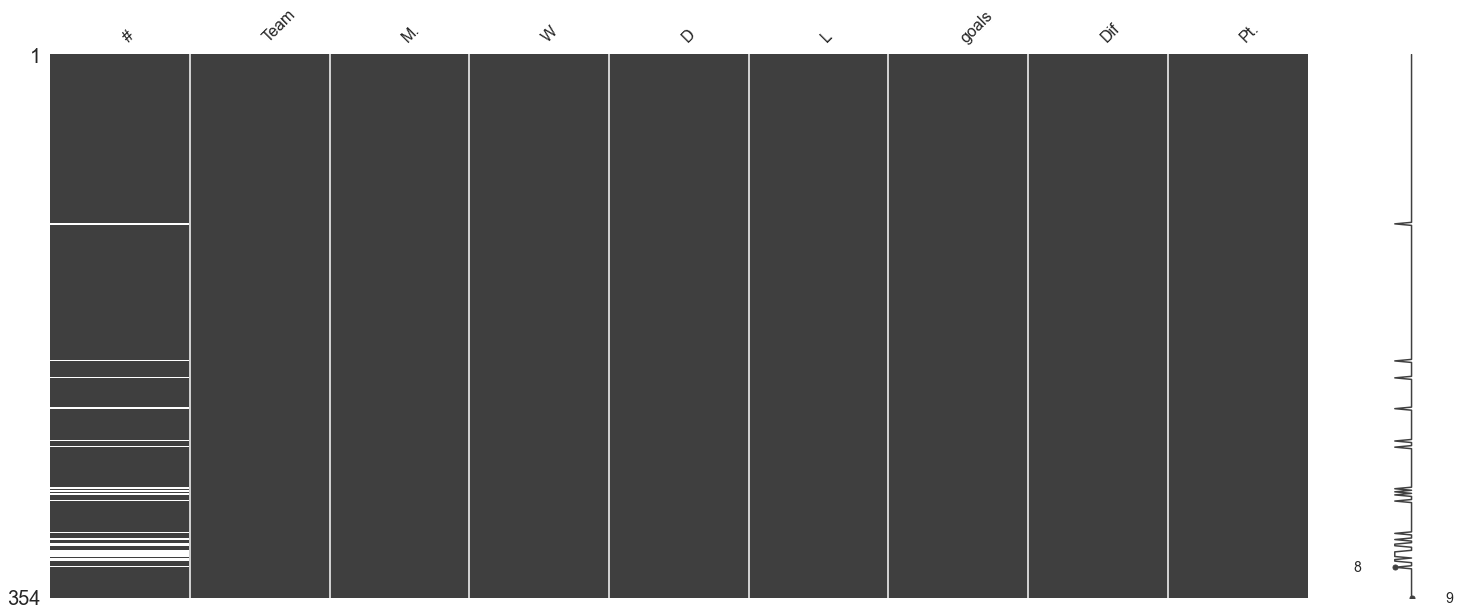

In [12]:
msno.matrix(all_time)

`all_time` dataset has only missing value in the '#' column. However since this column is useless and not informative we can drop it.

In [13]:
all_time.drop('#',axis=1,inplace=True)

<Axes: >

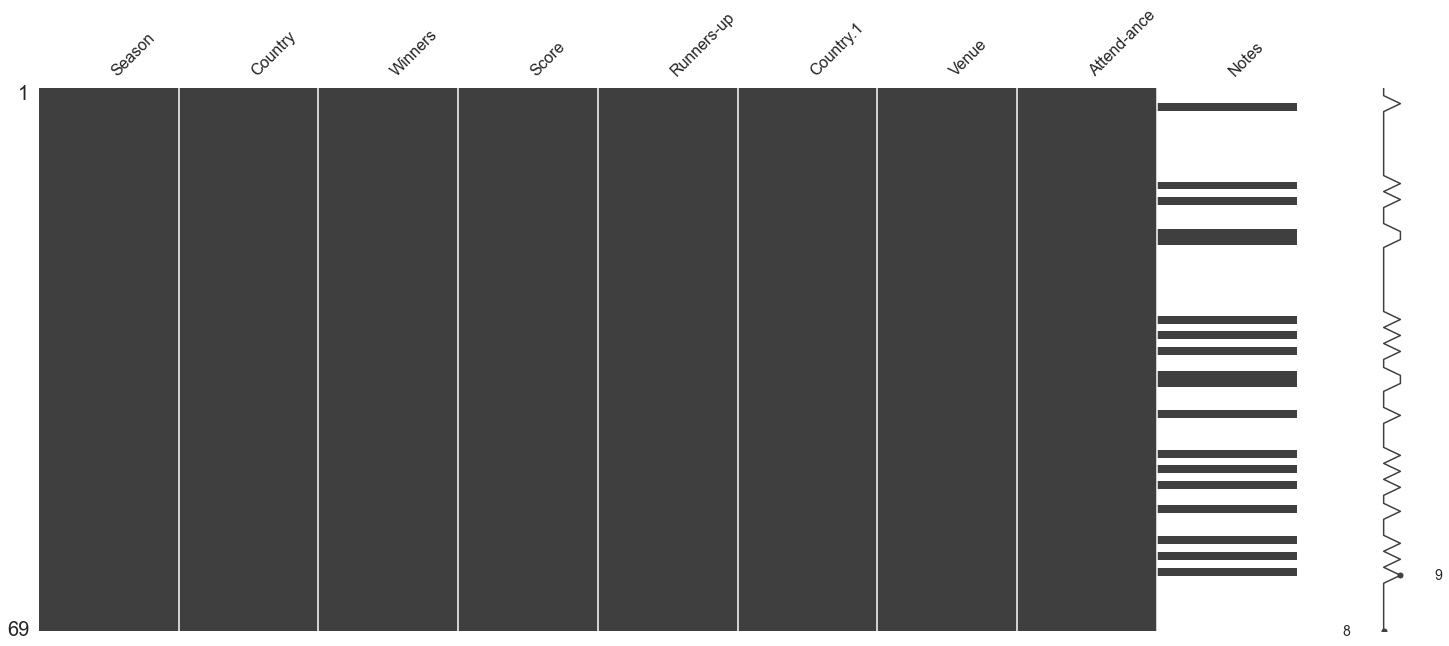

In [14]:
msno.matrix(finals)

`finals` dataset has missing value only in the `Notes` column. However this column states whether the match has been concluded with penalties or extra-time. `NaN` values in this column mean that the match ended within the regular time.

In [15]:
#fill nan values in the Notes colums
finals['Notes'].fillna('Match was won during regular time',inplace=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_14216\1469474397.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  finals['Notes'].fillna('Match was won during regular time',inplace=True)


## Formatting columns

### all_time dataset

`goals` column has some issues because it is inconsistent with `Dif` (the Goal Diffrence) column. Thus, we drop both columns.
Moreover, `Pt.` column does not correspond to $3\times W+1\times D+0\times L$ so we will create a new column respecting this rule.

In [16]:
all_time.drop(['goals','Dif','Pt.'],axis=1,inplace=True)

# Add Points column
all_time['Points']=pd.Series(all_time['W']*3+all_time['D']*1)

For Data Analysis' purpose we will create new columns Win Ratio, Draw Ratio, Loss Ratio and Win/Loss Ratio.

In [17]:
# Add win, draw and loss ratio columns
all_time['W %']=100*all_time['W']/all_time['M.']
all_time['D %']=100*all_time['D']/all_time['M.']
all_time['L %']=100*all_time['L']/all_time['M.']

# Add win/loss ratio column
all_time['W/L ratio']=all_time['W %']/all_time['L %']

# Rename column
all_time.rename(columns={'M.':'Matches'},inplace=True)

### finals dataset

For Data Analysis' purpose we will create new columns in the `finals` dataset.

In particular we will add a column for the number of goal scored by the winner, the runners-up and the total of goals.

Moreover we will also consider the `Year` of a Season as the year correspondent to the second half of the season.

In [18]:
# Add winners' goals, runners-up's goals and total goals columns
finals['win_score']=finals['Score'].apply(lambda x: int(x.split('–')[0]))
finals['run_score']=finals['Score'].apply(lambda x: int(x.split('–')[1]))
finals['tot_goals']=finals['win_score']+finals['run_score']

#Add a column Year
finals['Year']=finals['Season'].apply(lambda x: int(x.split('–')[0])+1)

In [19]:
#Rename some columns
finals.rename(columns={'Attend­ance':'Attendance','Country.1':'Country 2'},inplace=True)

In [20]:
#This function saves the last word after comma in the Venue column for each row
finals['Venue'] = finals['Venue'].apply(lambda x: x.split(',')[-1].strip())
#Convert string Attendance to float
finals['Attendance'] = finals['Attendance'].apply(lambda x: float(x.replace(',','')))

# Overview statistics

In [21]:
all_time.head()

,Team,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
0,Real Madrid,486,291,85,110,958,59.876543,17.489712,22.633745,2.645455
1,Bayern Munich,388,231,78,79,771,59.536082,20.103093,20.360825,2.924051
2,FC Barcelona,341,196,77,68,665,57.478006,22.580645,19.941349,2.882353
3,Manchester United,289,153,69,67,528,52.941176,23.875433,23.183391,2.283582
4,Juventus,297,151,68,78,521,50.841751,22.895623,26.262626,1.935897


In [22]:
all_time.describe()

,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,353.00
mean,33.254237,13.039548,7.169492,13.039548,46.288136,25.694297,19.311845,54.973344,inf
std,61.581865,31.468472,13.729255,18.669137,107.450873,19.785070,16.293620,24.449384,NaN
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
25%,4.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,36.592072,0.00
50%,8.000000,2.000000,2.000000,5.000000,9.000000,25.000000,18.181818,50.000000,0.52
75%,31.500000,9.000000,6.000000,14.000000,35.000000,41.328600,26.626506,71.279762,1.00
max,486.000000,291.000000,85.000000,110.000000,958.000000,83.333333,100.000000,100.000000,inf


In [23]:
finals.head()

,Season,Country,Winners,Score,Runners-up,Country 2,Venue,Attendance,Notes,win_score,run_score,tot_goals,Year
0,1955–56,Spain,Real Madrid,4–3,Reims,France,France,38239.0,Match was won during regular time,4,3,7,1956
1,1956–57,Spain,Real Madrid,2–0,Fiorentina,Italy,Spain,124000.0,Match was won during regular time,2,0,2,1957
2,1957–58,Spain,Real Madrid,3–2,AC Milan,Italy,Belgium,67000.0,Match was won during extra time,3,2,5,1958
3,1958–59,Spain,Real Madrid,2–0,Reims,France,West Germany,72000.0,Match was won during regular time,2,0,2,1959
4,1959–60,Spain,Real Madrid,7–3,Eintracht Frankfurt,West Germany,Scotland,127621.0,Match was won during regular time,7,3,10,1960


In [24]:
finals.describe(include='object')

,Season,Country,Winners,Score,Runners-up,Country 2,Venue,Notes
count,69,69,69,69,69,69,69,69
unique,68,11,23,14,36,14,18,4
top,1973–74,Spain,Real Madrid,1–0,Juventus,Italy,Italy,Match was won during regular time
freq,2,19,14,19,7,17,9,51


Already by this summary table we can retrieve some key facts:

- 1973-1974 was a strange season with "two finals". Read more [here](https://en.wikipedia.org/wiki/1974_European_Cup_final).

- Real Madrid dominates the competition with 14 titles.
- Juventus is the "best" runners-up team.
- The most common score is 1-0 which occurred 19 times out of 69.
- Penalty shoot-out was necessary 11 times to declare a winner.

# Exploratory Data Analysis

## All Time performances

### Top and worst teams

Let's check which teams have the largest number of matches in UCL.

In [25]:
top10=all_time.sort_values(by='Matches',ascending=False).head(10)
top10.head()

,Team,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
0,Real Madrid,486,291,85,110,958,59.876543,17.489712,22.633745,2.645455
1,Bayern Munich,388,231,78,79,771,59.536082,20.103093,20.360825,2.924051
2,FC Barcelona,341,196,77,68,665,57.478006,22.580645,19.941349,2.882353
4,Juventus,297,151,68,78,521,50.841751,22.895623,26.262626,1.935897
3,Manchester United,289,153,69,67,528,52.941176,23.875433,23.183391,2.283582


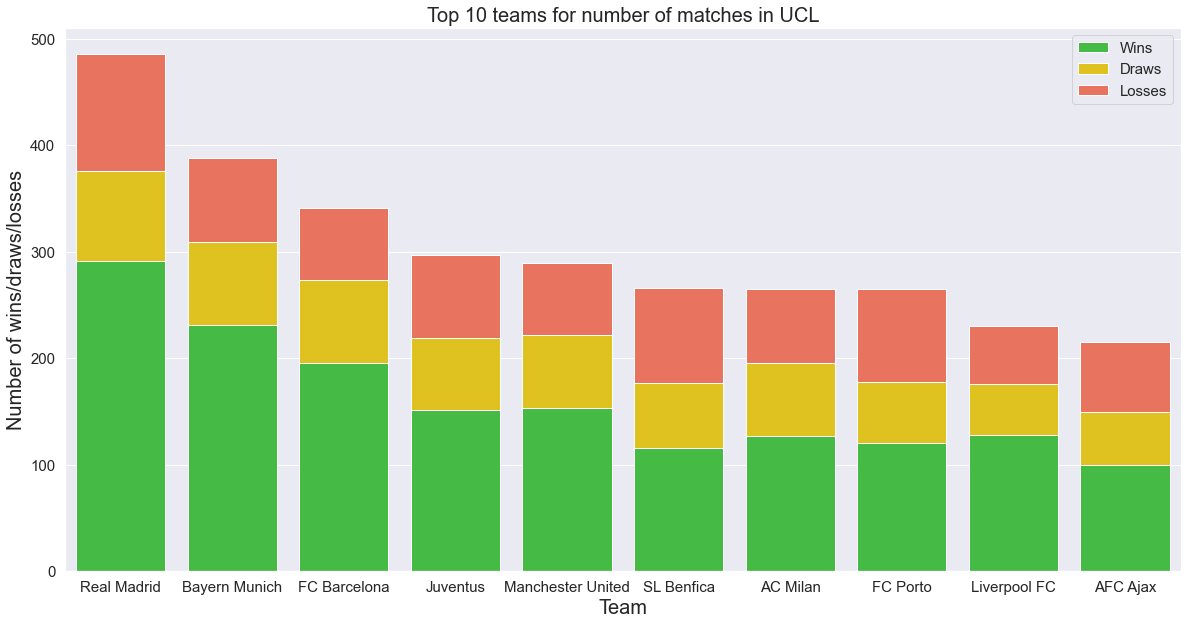

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.title('Top 10 teams for number of matches in UCL',fontsize=20)

# Plot 'W' (wins) as the bottom bars
sns.barplot(data=top10, x='Team', y='W', ax=ax, color='limegreen', label='Wins')

# Plot 'D' (draws) on top of 'W' (stacked bars)
sns.barplot(data=top10, x='Team', y='D', ax=ax, color='gold', label='Draws', bottom=top10['W'])

# Plot 'L' (losses) on top of 'D' (stacked bars)
sns.barplot(data=top10, x='Team', y='L', ax=ax, color='tomato', label='Losses', 
            bottom=top10['W']+top10['D'])

plt.ylabel('Number of wins/draws/losses',fontsize=20)
plt.xlabel('Team',fontsize=20)
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=15)
plt.savefig(path+os.sep+'top10_matches.png',dpi=300, bbox_inches='tight')

Despite Real Madrid is the team with the largest number of victories in the UCL, it is not the team with the lowest rate of losses. 
Let's examine this aspect.

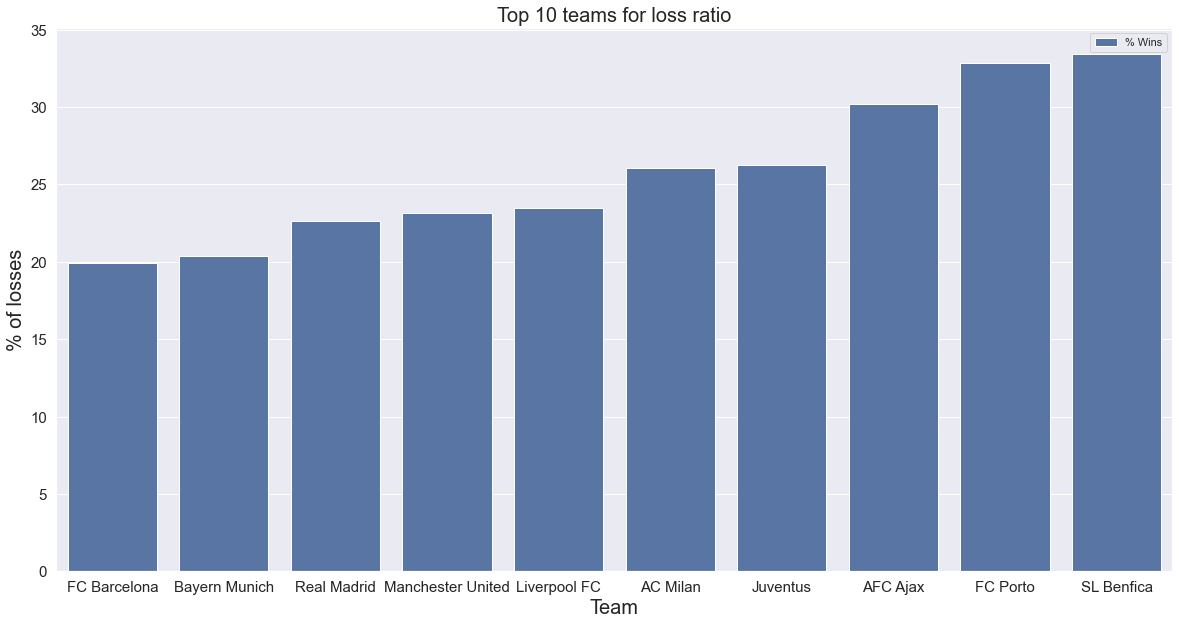

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.title('Top 10 teams for loss ratio',fontsize=20)
# Plot 'W' (wins) as the bottom bars
sns.barplot(data=top10.sort_values(by='L %'), x='Team', y='L %', ax=ax, label='% Wins')
plt.ylabel('% of losses',fontsize=20)
plt.xlabel('Team',fontsize=20)
plt.tick_params(axis='both',labelsize=15)

plt.savefig(path+os.sep+'top10_lossratio.png',dpi=300, bbox_inches='tight')

Indeed, FC Barcelona and Bayern Munich are the best teams with respect to the loss ratio. However, Real Madrid is still in third position despite more than 100 extra matches.

Another key feature to evaluate is the ratio between wins and losses.

In [28]:
all_time.sort_values(by='W/L ratio',ascending=False)

,Team,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
206,Zbrojovka Brno,4,1,3,0,6,25.000000,75.000000,0.000000,inf
140,FC Ararat,6,5,0,1,15,83.333333,0.000000,16.666667,5.00
147,AFC DWS,6,4,1,1,13,66.666667,16.666667,16.666667,4.00
98,1. FC Köln,17,7,8,2,29,41.176471,47.058824,11.764706,3.50
74,Spartak Trnava,24,13,7,4,46,54.166667,29.166667,16.666667,3.25
...,...,...,...,...,...,...,...,...,...,...
318,Pezoporikos Larnaca,2,0,0,2,0,0.000000,0.000000,100.000000,0.00
319,Tavriya Simferopol (1958-2014),2,0,0,2,0,0.000000,0.000000,100.000000,0.00
320,Ilves Tampere,2,0,0,2,0,0.000000,0.000000,100.000000,0.00
353,Avenir Beggen,8,0,0,8,0,0.000000,0.000000,100.000000,0.00


We need to put a threshold value on the number of matches, otherwise this table would be unreliable. We selected $50$ but it is arbitrary. Changing this threshold value would change the findings obtained in this analysis.

In [29]:
thresh_val=50

In [30]:
top10_wl_ratio=all_time[all_time['Matches']>thresh_val]
top10_wl_ratio=top10_wl_ratio.sort_values(by='W/L ratio',ascending=False).head(10)
top10_wl_ratio

,Team,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
1,Bayern Munich,388,231,78,79,771,59.536082,20.103093,20.360825,2.924051
2,FC Barcelona,341,196,77,68,665,57.478006,22.580645,19.941349,2.882353
0,Real Madrid,486,291,85,110,958,59.876543,17.489712,22.633745,2.645455
16,Manchester City,127,72,26,29,242,56.692913,20.472441,22.834646,2.482759
6,Liverpool FC,230,128,48,54,432,55.652174,20.869565,23.478261,2.370370
9,Chelsea FC,197,101,52,44,355,51.269036,26.395939,22.335025,2.295455
3,Manchester United,289,153,69,67,528,52.941176,23.875433,23.183391,2.283582
4,Juventus,297,151,68,78,521,50.841751,22.895623,26.262626,1.935897
5,AC Milan,265,127,69,69,450,47.924528,26.037736,26.037736,1.840580
14,Atlético Madrid,166,79,44,43,281,47.590361,26.506024,25.903614,1.837209


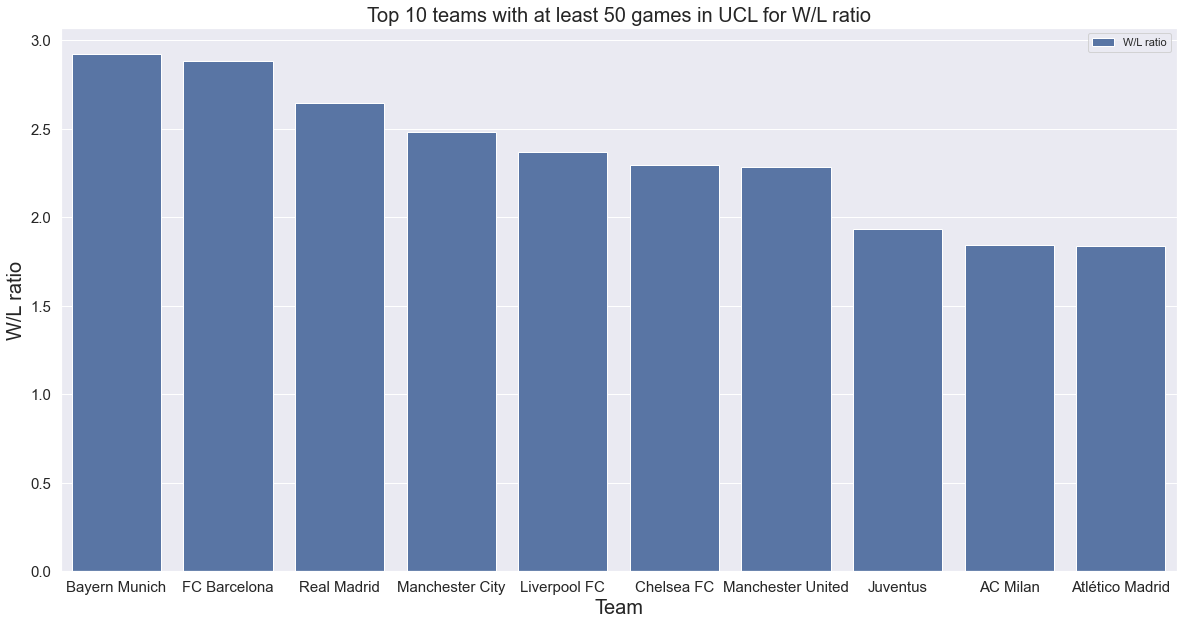

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.title('Top 10 teams with at least 50 games in UCL for W/L ratio',fontsize=20)
# Plot 'W' (wins) as the bottom bars
sns.barplot(data=top10_wl_ratio, x='Team', y='W/L ratio',  label='W/L ratio')
plt.ylabel('W/L ratio',fontsize=20)
plt.xlabel('Team',fontsize=20)
plt.tick_params(axis='both',labelsize=15)

plt.savefig(path+os.sep+'top10_wlratio.png',dpi=300, bbox_inches='tight')

Again we find that Bayern Munich and FC Barcelona are the best team for W/L ratio with Real Madrid in third position. We notice the presence of new teams in this rank like Manchester City, Chelsea FC and Atletico Madrid.

Now we can ask which are the teams that played at least 50 games with the worst W/L ratio. 

In [32]:
all_time.sort_values(by='W/L ratio')

,Team,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
292,Lisburn Distillery,2,0,1,1,1,0.000000,50.000000,50.000000,0.0
291,FC Lausanne-Sport,2,0,1,1,1,0.000000,50.000000,50.000000,0.0
290,St Patrick's Athletic,2,0,1,1,1,0.000000,50.000000,50.000000,0.0
289,Rot-Weiss Essen,2,0,1,1,1,0.000000,50.000000,50.000000,0.0
296,Skonto FC,4,0,1,3,1,0.000000,25.000000,75.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
98,1. FC Köln,17,7,8,2,29,41.176471,47.058824,11.764706,3.5
147,AFC DWS,6,4,1,1,13,66.666667,16.666667,16.666667,4.0
140,FC Ararat,6,5,0,1,15,83.333333,0.000000,16.666667,5.0
206,Zbrojovka Brno,4,1,3,0,6,25.000000,75.000000,0.000000,inf


In [33]:
worst10_wl_ratio=all_time[all_time['Matches']>thresh_val]
worst10_wl_ratio=worst10_wl_ratio.sort_values(by='W/L ratio',ascending=True).head(10)
worst10_wl_ratio

,Team,Matches,W,D,L,Points,W %,D %,L %,W/L ratio
93,Dinamo Zagreb,54,8,9,37,33,14.814815,16.666667,68.518519,0.216216
76,AEK Athen,56,9,19,28,46,16.071429,33.928571,50.000000,0.321429
64,Beşiktaş,70,17,13,40,64,24.285714,18.571429,57.142857,0.425000
49,Rosenborg BK,90,21,21,48,84,23.333333,23.333333,53.333333,0.437500
60,Fenerbahçe,73,20,10,43,70,27.397260,13.698630,58.904110,0.465116
68,Malmö FF,53,14,11,28,53,26.415094,20.754717,52.830189,0.500000
46,CSKA Moskva,86,23,20,43,89,26.744186,23.255814,50.000000,0.534884
23,Galatasaray,161,43,41,77,170,26.708075,25.465839,47.826087,0.558442
43,Sporting CP,92,28,15,49,99,30.434783,16.304348,53.260870,0.571429
24,Olympiakos Piraeus,156,47,28,81,169,30.128205,17.948718,51.923077,0.580247


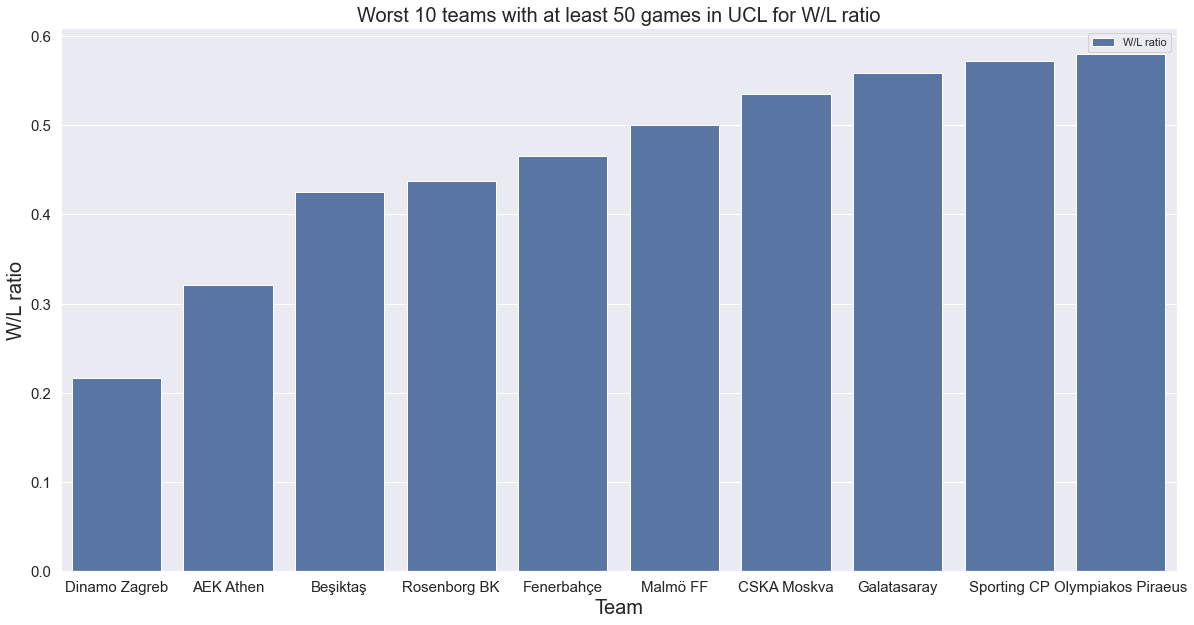

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.title('Worst 10 teams with at least 50 games in UCL for W/L ratio',fontsize=20)
# Plot 'W' (wins) as the bottom bars
sns.barplot(data=worst10_wl_ratio, x='Team', y='W/L ratio',  label='W/L ratio')
plt.ylabel('W/L ratio',fontsize=20)
plt.xlabel('Team',fontsize=20)
plt.tick_params(axis='both',labelsize=15)

plt.savefig(path+os.sep+'bot10_wlratio.png',dpi=300, bbox_inches='tight')

Dinamo Zagreb is the worst team for W/L ratio ($\approx 22\%$) with at least $50$ UCL games. Soon after, we find AEK Athen ($\approx 32\%$). 

### Number of matches vs Number of wins

Now let's explore if any correlation exists between the number of matches and the number of wins.

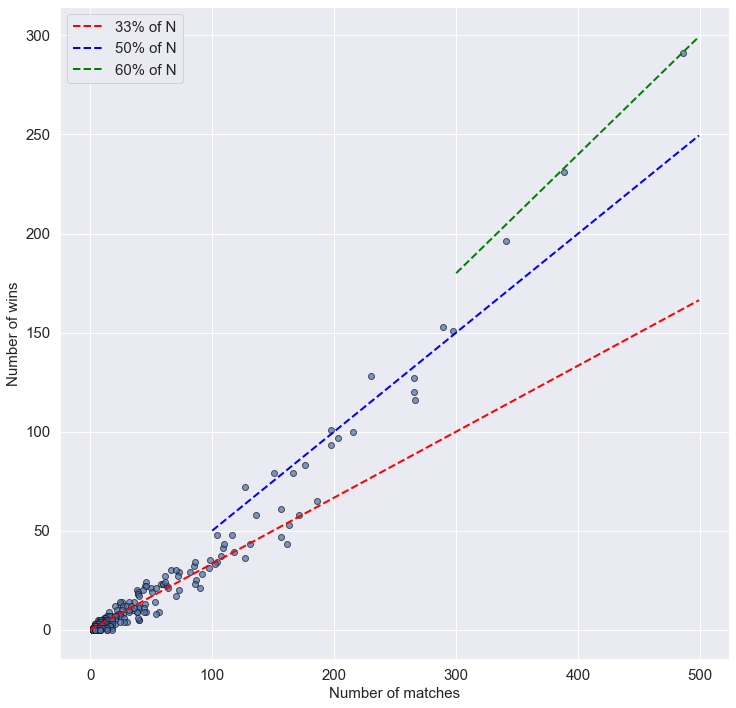

In [35]:
x_data=np.arange(0,500,1)
plt.figure(figsize=(12,12))
plt.scatter(all_time['Matches'],all_time['W'],edgecolors='k',alpha=0.7)
plt.xlabel('Number of matches',fontsize=15)
plt.ylabel('Number of wins',fontsize=15)
plt.plot(x_data,[x/3 for x in x_data],lw=2,linestyle='--',c='red',label='33% of N')
plt.plot(x_data[100:],[x/2 for x in x_data[100:]],lw=2,linestyle='--',c='blue',label='50% of N')
plt.plot(x_data[300:],[6*x/10 for x in x_data[300:]],lw=2,linestyle='--',c='green',label='60% of N')
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=15)

We notice that there is an increasing trend of wins as the number of matches increases. However this is not just a simple reflection of the [Law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers), i.e. the number of wins tends to the probability fraction of the event times the number of cases. If it was the case then the probability to win is 1/3. Thus after 500 matches one would expect Real Madrid to win $500/3\approx 167$ games. However Real Madrid has won 291 matches out of 486 ($\approx 59%$ win rate). This means that the more games a team plays, the more experience it gains.  From the plot above we see that till $\approx 100$ games, number of wins is nearly 1/3 of the number of matches. From $\approx 100$ games, it's like teams acquired enough experience to face with UCL games. 

Let's test which function better describe the distribution of (N matches, N wins)

In [36]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
# Linear function
def linear_func(x, a, b):
    return a * x + b

# Quadratic function
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

In [38]:
# Fit each function to the data
popt_linear, _ = curve_fit(linear_func, all_time['Matches'], all_time['W'])
popt_quadratic, _ = curve_fit(quadratic_func, all_time['Matches'], all_time['W'])

In [39]:
Y_pred_linear = linear_func(all_time['Matches'], *popt_linear)
Y_pred_quadratic = quadratic_func(all_time['Matches'], *popt_quadratic)

# Calculate fit metrics
def evaluate_fit(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

metrics = {
    "Linear": evaluate_fit(all_time['W'], Y_pred_linear),
    "Quadratic": evaluate_fit(all_time['W'], Y_pred_quadratic),
}

for func_name, (mse, r2) in metrics.items():
    print(f"{func_name} - MSE: {mse:.4f}, R-squared: {r2:.4f}")

Linear - MSE: 49.0233, R-squared: 0.9504
Quadratic - MSE: 19.4601, R-squared: 0.9803


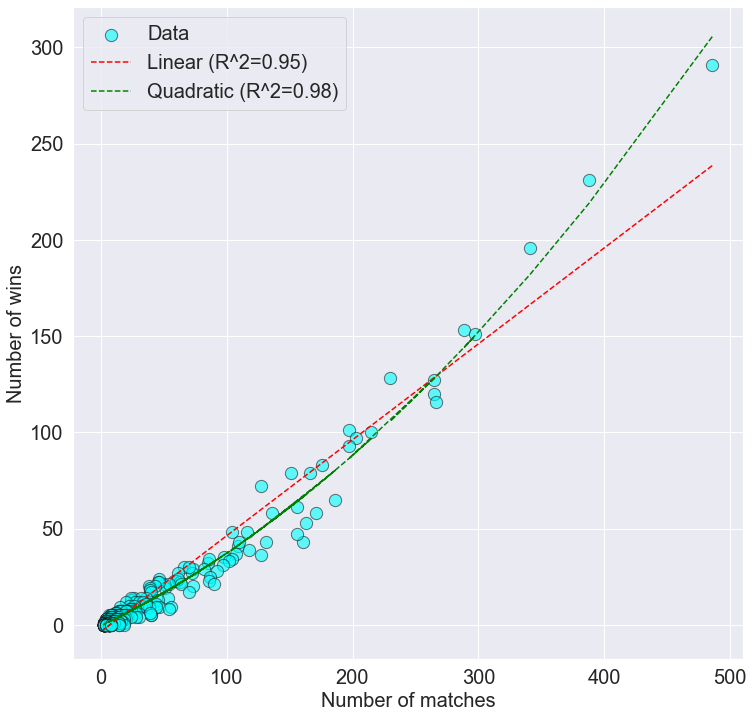

In [40]:
plt.figure(figsize=(12,12))
plt.scatter(all_time['Matches'], all_time['W'], label="Data", color='aqua',alpha=0.6,s=150,edgecolors='k')

plt.plot(all_time['Matches'], Y_pred_linear, label=f"Linear (R^2={metrics['Linear'][1]:.2f})", color='red',linestyle='--')
plt.plot(all_time['Matches'], Y_pred_quadratic, label=f"Quadratic (R^2={metrics['Quadratic'][1]:.2f})", 
         color='green',linestyle='--')
#plt.plot(all_time['Matches'], Y_pred_exponential, label=f"Exponential (R^2={metrics['Exponential'][1]:.2f})", color='blue')
plt.xlabel('Number of matches',fontsize=20)
plt.ylabel('Number of wins',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.legend(fontsize=20)

From the R-squared and MSE metrics we retrieve that the quadratic fit better descrobes the behaviour of our data over the simple linear correlation.
This might indicate that the process of learning and experience is not linear but quadratic in a first raw approximation. Further data and studies might shed light upon this issue. For example what about an exponential fit? Could Machine Learning algorithms be used to predict the number of wins given the number of matches?

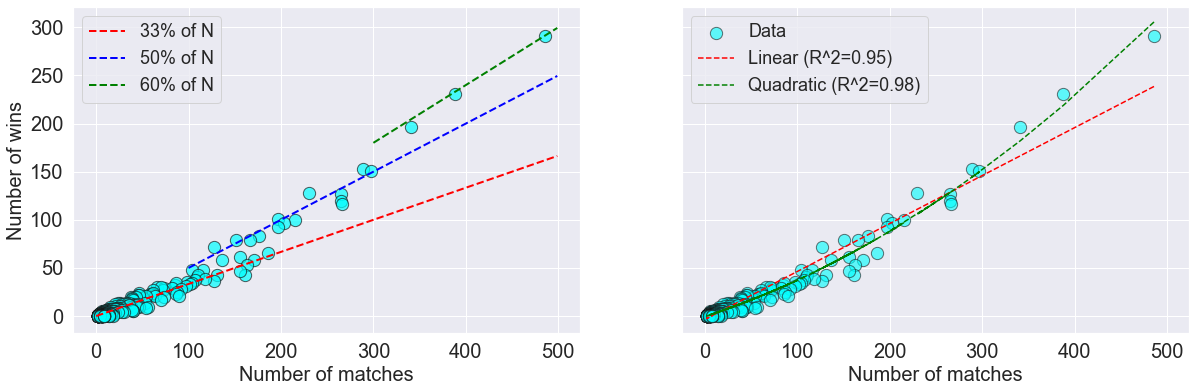

In [41]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,6),sharex=True,sharey=True)

ax[0].scatter(all_time['Matches'],all_time['W'],edgecolors='k',alpha=0.7,c='aqua',s=150)
ax[0].set_xlabel('Number of matches',fontsize=20)
ax[0].set_ylabel('Number of wins',fontsize=20)
ax[0].plot(x_data,[x/3 for x in x_data],lw=2,linestyle='--',c='red',label='33% of N')
ax[0].plot(x_data[100:],[x/2 for x in x_data[100:]],lw=2,linestyle='--',c='blue',label='50% of N')
ax[0].plot(x_data[300:],[6*x/10 for x in x_data[300:]],lw=2,linestyle='--',c='green',label='60% of N')
ax[0].tick_params(axis='both',labelsize=20)
ax[0].legend(fontsize=18)


ax[1].scatter(all_time['Matches'], all_time['W'], label="Data", color='aqua',alpha=0.6,s=150,edgecolors='k')
ax[1].plot(all_time['Matches'], Y_pred_linear, label=f"Linear (R^2={metrics['Linear'][1]:.2f})", color='red',linestyle='--')
ax[1].plot(all_time['Matches'], Y_pred_quadratic, label=f"Quadratic (R^2={metrics['Quadratic'][1]:.2f})", 
        color='green',linestyle='--')
ax[1].set_xlabel('Number of matches',fontsize=20)
ax[1].tick_params(axis='both',labelsize=20)
ax[1].legend(fontsize=18)

fig.savefig(path+os.sep+'matches_wins.png',dpi=300,bbox_inches='tight')

### Correlation map

We here analyze the correlation between features. However since `W`, `D`, `L` and `Points`  are clearly linked to `Matches` and `Points` we will exclude them because of redundance.

In [42]:
stats.shapiro(all_time['Matches']),stats.shapiro(all_time['W %']),stats.shapiro(all_time['D %']),stats.shapiro(all_time['L %'])

(ShapiroResult(statistic=np.float64(0.5375005699716133), pvalue=np.float64(1.8482429166200496e-29)),
 ShapiroResult(statistic=np.float64(0.9270861620983203), pvalue=np.float64(4.015995702258462e-12)),
 ShapiroResult(statistic=np.float64(0.9065446896550793), pvalue=np.float64(5.630185636395691e-14)),
 ShapiroResult(statistic=np.float64(0.9296661199749535), pvalue=np.float64(7.253724159226224e-12)))

Since data are not normally distributed and we have already noticed that there is a non-linear relationship between `Matches` and `W` we opted to employ the *Spearman* method instead of *Pearson*.

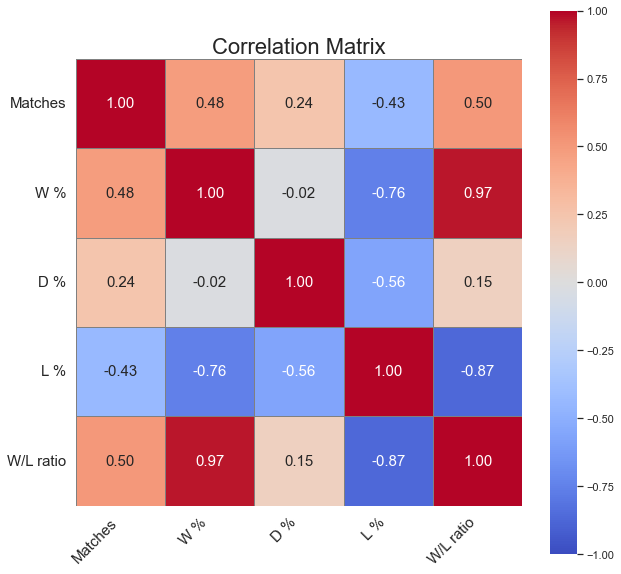

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(all_time.drop(columns=['Team','W','D','L','Points']).corr(method='spearman'), 
            annot=True,           # Annotate the cells with the correlation values
            fmt='.2f',            # Format the annotation text (two decimal places)
            cmap='coolwarm',      # Choose a color map
            cbar=True,            # Show the color bar
            square=True,          # Make each cell square-shaped
            linewidths=.5,        # Add space between the cells
            linecolor='gray',     # Color of the lines between cells
            annot_kws={"size": 15},# Annotation font size
            vmin=-1, vmax=1)      # Set the min and max values for the color scale

# Set titles and labels for clarity
plt.title('Correlation Matrix', fontsize=22)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=12)               # Rotate y-axis labels
plt.tick_params(axis='both',labelsize=15)

# Display the plot
plt.savefig(path+os.sep+'all_time_corr.png',dpi=300,bbox_inches='tight')

As expected the number of matches mildly depends on the `W %` since more wins correspond to more matches. At the same way the number of matches is negative correlated with `L %`.

### UCL Titles distribution across Europe

Let's conclude the analysis of the `all_time` dataset by studying how the UCL titles are distributed across the Europe using the [`geopandas`](https://geopandas.org/en/stable/) package.

In [102]:
wins_series=finals['Country'].value_counts()
wins_series

Country
Spain           19
England         15
Italy           12
Netherlands      6
West Germany     5
Portugal         4
Germany          4
Scotland         1
Romania          1
Yugoslavia       1
France           1
Name: count, dtype: int64

This series has some issues: Germany and West Germany should be unified under Germany label. Yugoslavia does not exist anymore and it is not contained within the geopandas packages so we need to drop it and add all the [countries](https://history.state.gov/countries/kingdom-of-yugoslavia#:~:text=In%201929%20the%20Kingdom%20of,Republic%20of%20Yugoslavia%20(SFRY).) belonging to it.

In [ ]:
wins_series=wins_series.rename({'West Germany': 'Germany'}).groupby(level=0).sum()
wins_series.drop('Yugoslavia',inplace=True)

new_countries = ['Slovenia', 'Croatia', 'Bosnia and Herzegovina', 'Montenegro', 'North Macedonia', 'Serbia']
for country in new_countries:
    wins_series[country] = 1
    
wins_series

In [171]:
#load the geo_file
geo_file=path+os.sep+'geo_pandas'+os.sep+'ne_110m_admin_0_countries.shp'

In [172]:
# Load the map of Europe using GeoPandas
world = gpd.read_file(geo_file)
# Filter the map to only include Europe
europe = world[world['CONTINENT'] == 'Europe']

In [173]:
europe = europe.applymap(lambda x: x.replace('United Kingdom', 'England') if isinstance(x, str) else x)

C:\Users\chris\AppData\Local\Temp\ipykernel_14216\3826670946.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  europe = europe.applymap(lambda x: x.replace('United Kingdom', 'England') if isinstance(x, str) else x)


There is a problem with Scotland that is not included in the geopandas dataframe. We tried to figure out by manually downloading the .json file and adapting it to Europe.

In [174]:
scotland = gpd.read_file(path+os.sep+'geo_pandas'+os.sep+'scotland.json')
scotland.crs = 'EPSG:4326'

In [175]:
scotland['is_valid'] = scotland.is_valid

# Print rows with invalid geometries
print(scotland[~scotland['is_valid']])

          id    EER13CD EER13CDO   EER13NM  \
0  S15000001  S15000001       11  Scotland   

                                            geometry  is_valid  
0  MULTIPOLYGON (((-4.41187 54.68057, -4.41267 54...     False  


In [176]:
from shapely.geometry import shape
from shapely.ops import unary_union

# Apply buffer(0) to fix invalid geometries
scotland['geometry'] = scotland['geometry'].buffer(0)

# Recheck validity
scotland['is_valid'] = scotland.is_valid
print(scotland[~scotland['is_valid']])

Empty GeoDataFrame
Columns: [id, EER13CD, EER13CDO, EER13NM, geometry, is_valid]
Index: []


In [177]:
# Ensure both GeoDataFrames have the same CRS
if europe.crs != scotland.crs:
    scotland = scotland.to_crs(europe.crs)

In [178]:
# Proceed with merging Scotland into Europe
scotland_df = gpd.GeoDataFrame({
    'geometry': scotland.geometry,
    'Country': ['Scotland'] * len(scotland)
}, crs=europe.crs)

In [179]:
europe = pd.concat([europe, scotland_df], ignore_index=True)

In [180]:
# Merge the data with the geographical map
europe = europe.set_index('NAME').join(wins_series.rename('Wins'))

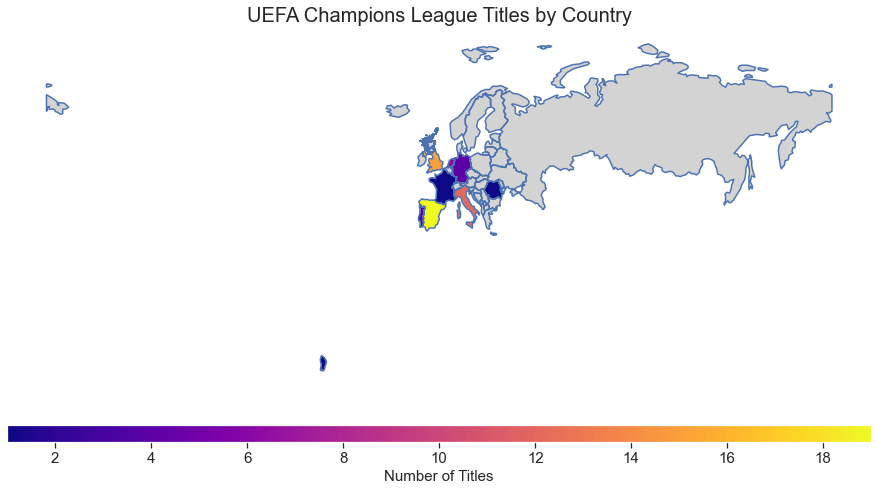

In [181]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))  # Large figure size
europe.boundary.plot(ax=ax)  # Plot country borders
# Define colormap and normalization
cmap = 'plasma'
norm = mpl.colors.Normalize(vmin=europe['Wins'].min(), vmax=europe['Wins'].max())
# Plot the map with the specified colormap and normalization
map_plot = europe.plot(column='Wins', ax=ax, cmap=cmap, norm=norm,
                       missing_kwds={"color": "lightgrey"})

# Customize plot
ax.set_title('UEFA Champions League Titles by Country', fontsize=20)  # Larger title
ax.axis('off')  # Remove the axes for better visualization

# Add a horizontal colorbar below the map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # The array is set to empty because the data is already in the plot

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Number of Titles', fontsize=15)

# Adjust layout to give more space to the map
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

plt.savefig(path+os.sep+'geo_pandas.png',dpi=300,bbox_inches='tight')

As we can see Scotland is not coloured properly. We will try to fix this issue in later versions of this notebook.

We conclude examining the distribution of the UCL titles across the years

In [121]:
# We need to remove the duplicate year 1974
pivot_df=finals[['Country','Year']].drop_duplicates(subset=['Year'])

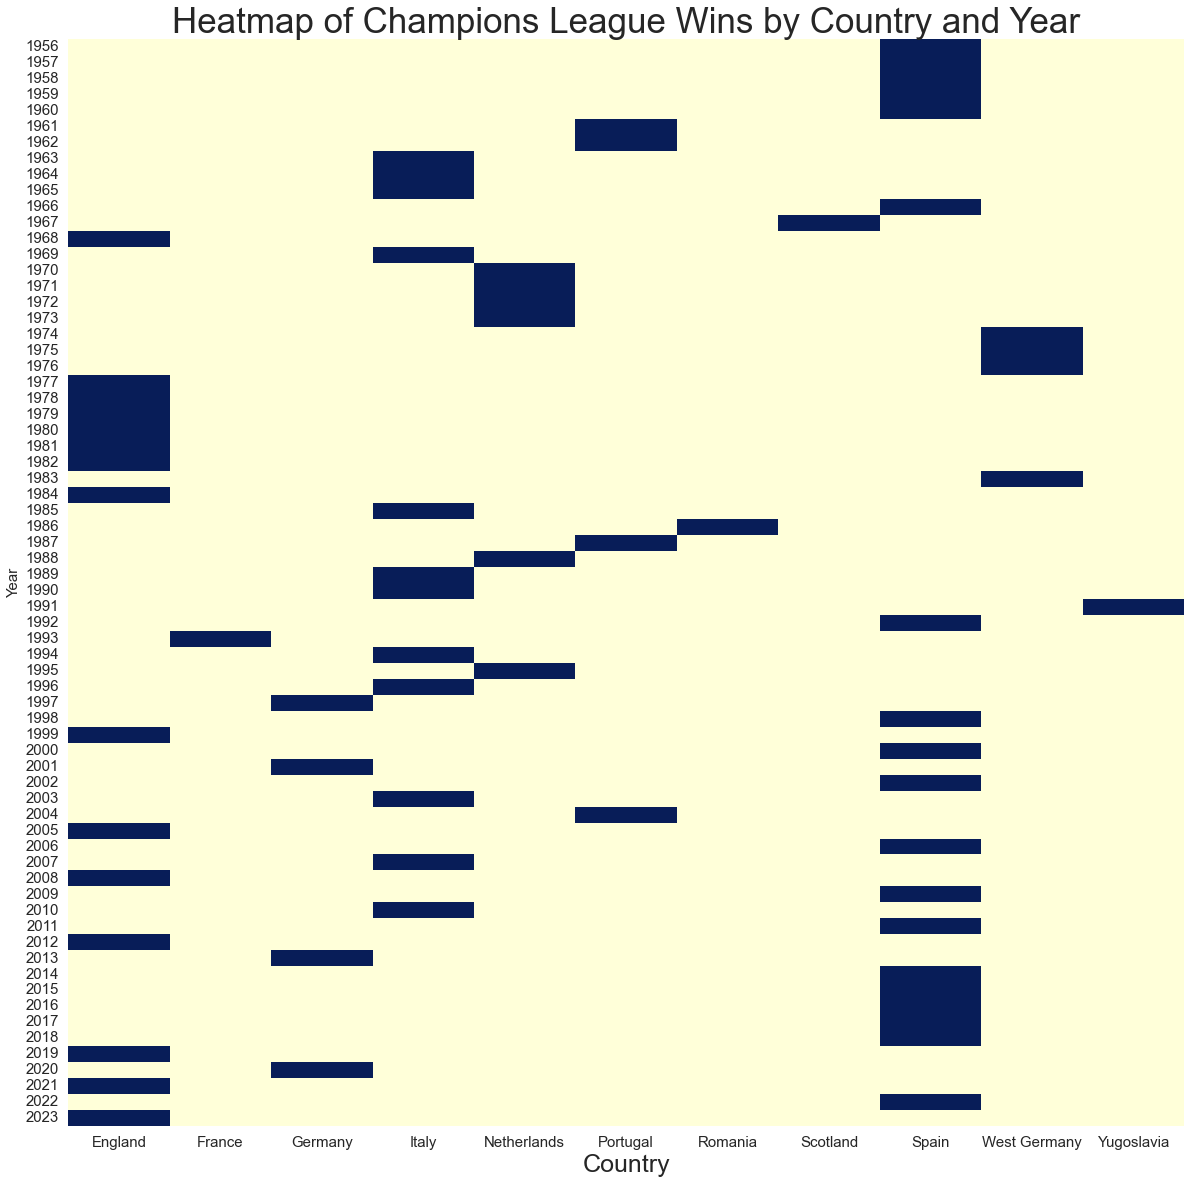

In [122]:
# Create a pivot table
pivot_table = pivot_df.pivot_table(index='Year', columns='Country', aggfunc='size', fill_value=0)

plt.figure(figsize=(20, 20))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False, fmt='d',cbar=False)
plt.title('Heatmap of Champions League Wins by Country and Year',fontsize=35)
plt.tick_params(axis='both',labelsize=15)
plt.xlabel('Country',fontsize=25)
plt.ylabel('Year',fontsize=15)

plt.savefig(path+os.sep+'win_country_years.png',dpi=300,bbox_inches='tight')

## Finals

### Winners and scores

Let's check which are the top 5 team in UCL for the number of won and lost finals.

In [123]:
top_winners = finals['Winners'].value_counts().head(5)
top_winners_df = top_winners.reset_index()
top_winners_df.columns = ['Team', 'Wins']

top_runners = finals['Runners-up'].value_counts().head(5)
top_runners_df = top_runners.reset_index()
top_runners_df.columns = ['Team', 'Losses']

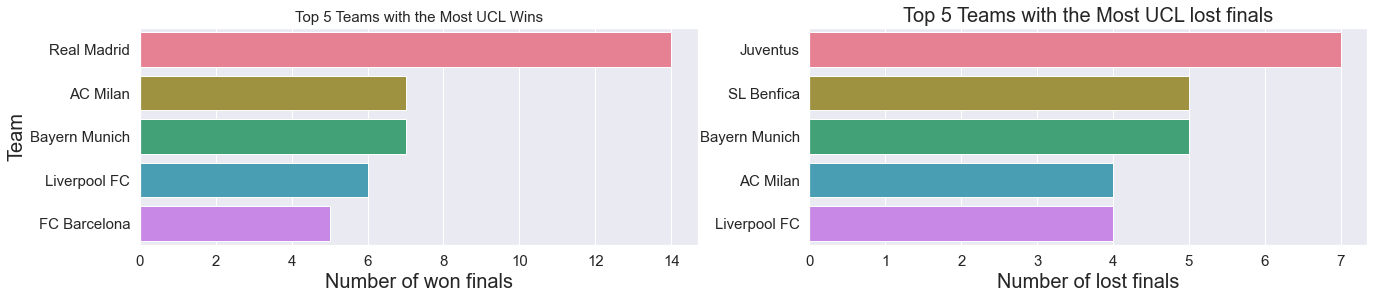

In [124]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(22,4))

ax[0].set_title('Top 5 Teams with the Most UCL Wins',fontsize=15)
sns.barplot(data=top_winners_df, x='Wins', y='Team',hue='Team',ax=ax[0],palette="husl")
ax[0].set_xlabel('Number of won finals',fontsize=20)
ax[0].set_ylabel('Team',fontsize=20)
ax[0].tick_params(axis='both',labelsize=15)

ax[1].set_title('Top 5 Teams with the Most UCL lost finals',fontsize=20)
sns.barplot(data=top_runners_df, x='Losses', y='Team',hue='Team',ax=ax[1],palette="husl")
ax[1].set_xlabel('Number of lost finals',fontsize=20)
ax[1].set_ylabel('')
ax[1].tick_params(axis='both',labelsize=15)

fig.savefig(path+os.sep+'top_bot_finalist.png',dpi=300,bbox_inches='tight')

Let's study the scores and the number of goals in the UCL finals.

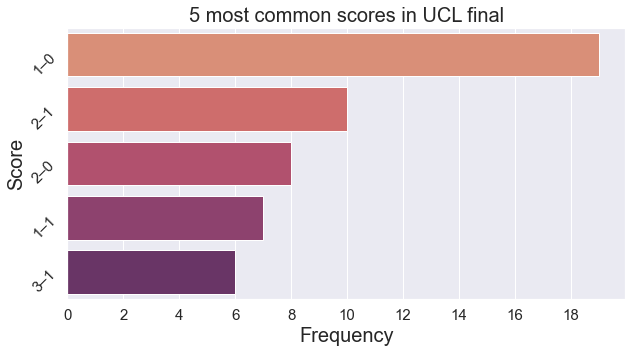

In [125]:
top_scores = finals['Score'].value_counts().head(5)
top_scores_df = top_scores.reset_index()
top_scores_df.columns = ['Score', 'Frequency']

plt.figure(figsize=(10,5))
sns.barplot(data=top_scores_df,x='Frequency',y='Score',hue='Score',palette='flare')
plt.title('5 most common scores in UCL final',fontsize=20)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Score',fontsize=20)
plt.xticks(np.arange(0,20,2))
plt.yticks(rotation=45)
plt.tick_params(axis='both',labelsize=15)
plt.savefig(path+os.sep+'top5_scores.png',dpi=300,bbox_inches='tight')

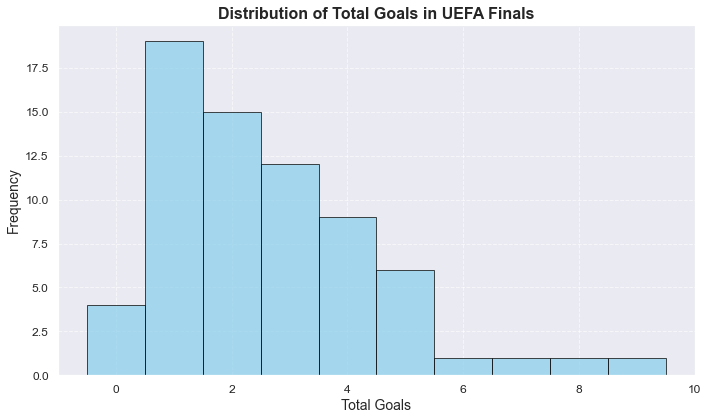

In [126]:
# Set figure size for better visibility
plt.figure(figsize=(10, 6))

plt.hist(finals['tot_goals'], bins=10, color='skyblue', edgecolor='black', alpha=0.7,align='left')

plt.title('Distribution of Total Goals in UEFA Finals', fontsize=16, fontweight='bold')
plt.xlabel('Total Goals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

The `tot_goals` are clearly not normally distributed since the distribution has a non negligible skewness. 

Let's test the normality with a Shapiro-Wilk test.

In [127]:
stats.shapiro(finals['tot_goals'])

ShapiroResult(statistic=np.float64(0.8833585167108916), pvalue=np.float64(1.0322090951756967e-05))

Let's check how the average number of total goals scored in a UCL final has changed over the years.

C:\Users\chris\AppData\Local\Temp\ipykernel_3388\1092125010.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_attendance_per_decade = finals.groupby('Decade')['tot_goals'].mean().reset_index()


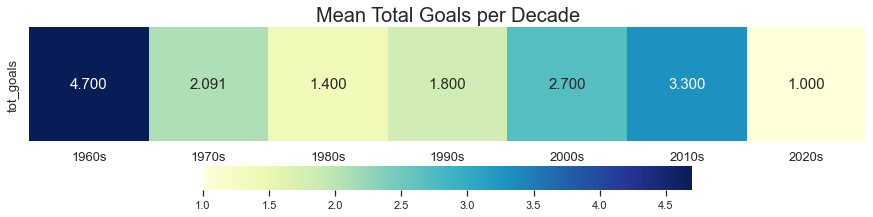

In [128]:
bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

finals['Decade'] = pd.cut(finals['Year'], bins=bins, labels=labels, right=False)

mean_attendance_per_decade = finals.groupby('Decade')['tot_goals'].mean().reset_index()

heatmap_data = mean_attendance_per_decade.set_index('Decade').T

plt.figure(figsize=(15, 3))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,annot_kws={"size": 15},
            cbar_kws={'orientation': 'horizontal'})
plt.title('Mean Total Goals per Decade',fontsize=20)

plt.tick_params(axis='both',labelsize=13)
#plt.xlabel('Decade')
plt.ylabel('')
plt.savefig(path+os.sep+'goals_per_decade.png',dpi=300,bbox_inches='tight')

We can appreciate a clear decrease of goal scored in a UCL final over the years. 

In [129]:
finals['Notes'].value_counts()

Notes
Match was won during regular time       51
Match was won on a penalty shoot-out    11
Match was won during extra time          5
Match was won after a replay             2
Name: count, dtype: int64

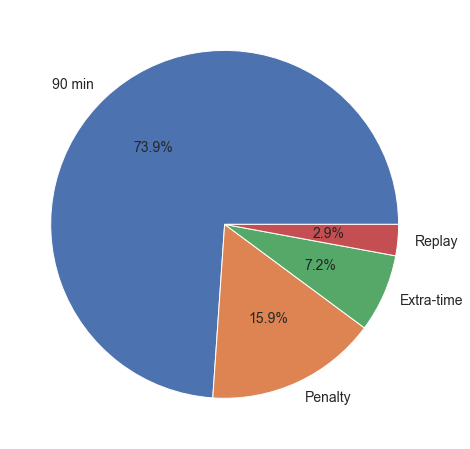

In [130]:
labels=['90 min','Penalty','Extra-time','Replay']
plt.figure(figsize=(8,8))
plt.pie(finals['Notes'].value_counts(),labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})

plt.savefig(path+os.sep+'notes_pie.png',dpi=300,bbox_inches='tight')

In [131]:
finals.groupby('Winners')['win_score'].mean()

Winners
AC Milan               2.428571
AFC Ajax               1.500000
Aston Villa            1.000000
Bayern Munich          1.714286
Borussia Dortmund      3.000000
Celtic FC              2.000000
Chelsea FC             1.000000
Crvena Zvezda          0.000000
FC Barcelona           2.200000
FC Porto               2.500000
Feyenoord              2.000000
Hamburger SV           1.000000
Inter Milan            2.000000
Juventus               1.000000
Liverpool FC           1.833333
Manchester City        1.000000
Manchester United      2.333333
Nottingham Forest      1.000000
Olympique Marseille    1.000000
PSV Eindhoven          0.000000
Real Madrid            2.785714
SL Benfica             4.000000
Steaua București       0.000000
Name: win_score, dtype: float64

In [132]:
finals.groupby('Winners')['win_score'].sum()

Winners
AC Milan               17
AFC Ajax                6
Aston Villa             1
Bayern Munich          12
Borussia Dortmund       3
Celtic FC               2
Chelsea FC              2
Crvena Zvezda           0
FC Barcelona           11
FC Porto                5
Feyenoord               2
Hamburger SV            1
Inter Milan             6
Juventus                2
Liverpool FC           11
Manchester City         1
Manchester United       7
Nottingham Forest       2
Olympique Marseille     1
PSV Eindhoven           0
Real Madrid            39
SL Benfica              8
Steaua București        0
Name: win_score, dtype: int64

### Attendance

Let's now study the Attendance during UCL finals over the years.

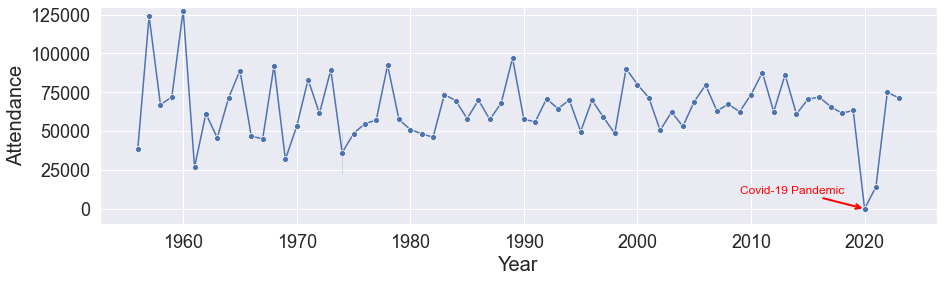

In [133]:
plt.figure(figsize=(15,4))

plt.ylim(-10000,130000)
sns.lineplot(data=finals,x='Year',y='Attendance',marker='o')

plt.annotate(
    'Covid-19 Pandemic',                # Annotation text
    xy=(2020, 0),             # Point to annotate
    xytext=(2009,10000),# Text location
    arrowprops=dict(edgecolor='red',facecolor='red', arrowstyle='->',lw=2),  # Arrow properties
    fontsize=12,                       # Font size
    color='red'                      # Font color
)

plt.xlabel('Year',fontsize=20)
plt.ylabel('Attendance',fontsize=20)
plt.tick_params(axis='both',labelsize=18)

plt.savefig(path+os.sep+'attendance_years.png',dpi=300,bbox_inches='tight')

Let's see what are the countries with the most attendance. 

In [134]:
mean_attendance_venue=finals.groupby('Venue')['Attendance'].mean()
top5_venues = mean_attendance_venue.sort_values(ascending=False).head(5)

In [135]:
#Select only venues with at least 5 UCL finals

value_counts = finals['Venue'].value_counts()
venues_to_keep = value_counts[value_counts > 4].index
filtered_venues = finals[finals['Venue'].isin(venues_to_keep)]

In [136]:
mean_attendance_venue=filtered_venues.groupby('Venue')['Attendance'].mean()
filtered_top5_venues = mean_attendance_venue.sort_values(ascending=False).head(5)

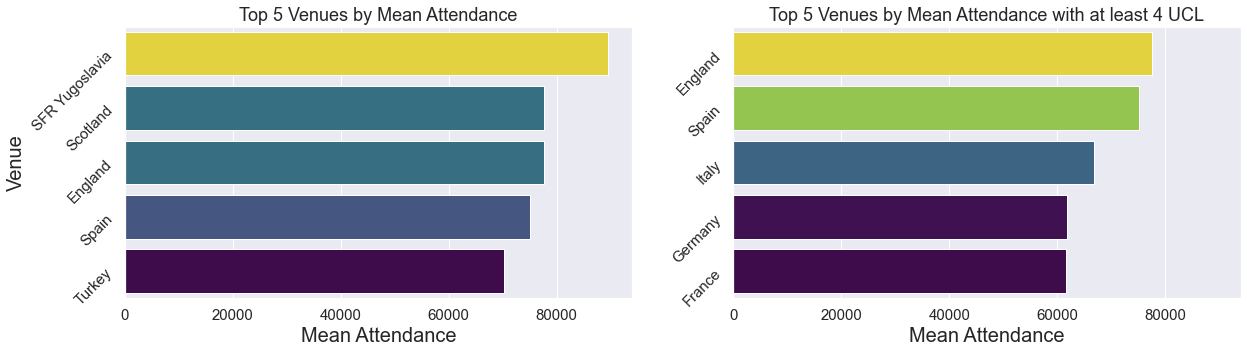

In [137]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5),sharex=True)

sns.barplot(y=top5_venues.index, x=top5_venues.values, palette='viridis',
            hue=top5_venues.values,ax=ax[0]).legend_.remove()

ax[0].set_ylabel('Venue', fontsize=20)
ax[0].set_xlabel('Mean Attendance', fontsize=20)
ax[0].set_title('Top 5 Venues by Mean Attendance', fontsize=18)
ax[0].tick_params(axis="y", rotation=45,labelsize=15) 
ax[0].tick_params(axis="x",labelsize=15)


sns.barplot(y=filtered_top5_venues.index, x=filtered_top5_venues.values,hue=filtered_top5_venues,
            palette='viridis',ax=ax[1]).legend_.remove()

ax[1].set_ylabel('', fontsize=15)
ax[1].set_xlabel('Mean Attendance', fontsize=20)
ax[1].set_title('Top 5 Venues by Mean Attendance with at least 4 UCL', fontsize=18)
ax[1].tick_params(axis="y", rotation=45,labelsize=15)
ax[1].tick_params(axis="x",labelsize=15)


fig.savefig(path+os.sep+'top_venues.png',dpi=300,bbox_inches='tight')

In [138]:
finals['Country'].value_counts()

Country
Spain           19
England         15
Italy           12
Netherlands      6
West Germany     5
Portugal         4
Germany          4
Scotland         1
Romania          1
Yugoslavia       1
France           1
Name: count, dtype: int64

I want to check if `Attendance` is somehow affected by the fact one of the two teams are playing in their country.

In [139]:
finals['same_country']=(finals['Country']==finals['Venue'])|(finals['Country 2']==finals['Venue'])

C:\Users\chris\AppData\Local\Temp\ipykernel_3388\2542470744.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=finals,x='same_country',y='Attendance',palette=['coral','lawngreen'])


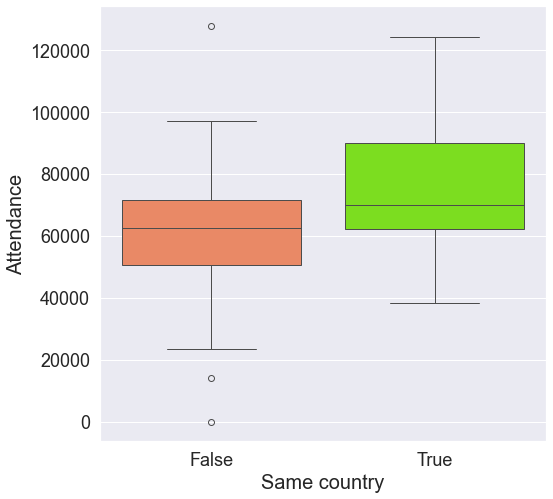

In [140]:
plt.figure(figsize=(8,8))
sns.boxplot(data=finals,x='same_country',y='Attendance',palette=['coral','lawngreen'])
plt.xlabel('Same country',fontsize=20)
plt.ylabel('Attendance',fontsize=20)
plt.tick_params(axis='both',labelsize=18)

plt.savefig(path+os.sep+'attendance_home.png',dpi=300,bbox_inches='tight')

There is a clear statistical difference between Attendance if one of the two teams are playing home or not.

The outlier at "127621" corresponds to 1959-1960 UCL Final between Real Madrid - Eintracht Frankfurt (7-3) which took place in Scotland. 

Let's perform a hypothesis test.

In [141]:
sample1=finals[finals['same_country']==True]['Attendance']
sample2=finals[finals['same_country']==False]['Attendance']

mannwhitneyu(sample1, sample2,use_continuity=True, alternative='two-sided', method='auto')

MannwhitneyuResult(statistic=np.float64(474.0), pvalue=np.float64(0.03735192226066969))

### Does playing home affect the result?

We want to check if there are any psychological advantages for a team playing UCL final in its own country.

To do this I need to add in `finals` a boolean column "same_country_win" which is `True` if the winners played the final in their country and `False` if not.

Similarly I need to add in `finals` a boolean column "same_country_loss" which is `True` if the runners-up played the final in their country and `False` if not.

In [142]:
finals['same_country_win']=finals['Country']==finals['Venue']
finals['same_country_loss']=finals['Country 2']==finals['Venue']

Let's make a pie chart to understand the proportion between home wins and home losses

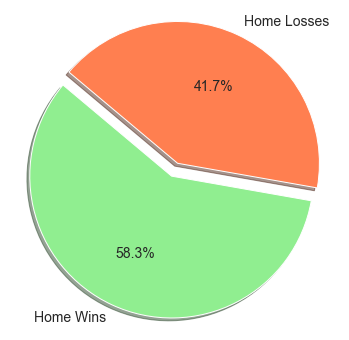

In [143]:
labels = ['Home Wins', 'Home Losses']
sizes = [sum(finals['same_country_win']), sum(finals['same_country_loss'])]
colors = ['lightgreen', 'coral']
explode = (0.1, 0)  # explode 1st slice

# Plotting the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140,
       textprops={'fontsize': 14})

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the plot
plt.savefig(path+os.sep+'pie_home.png',dpi=100,bbox_inches='tight')

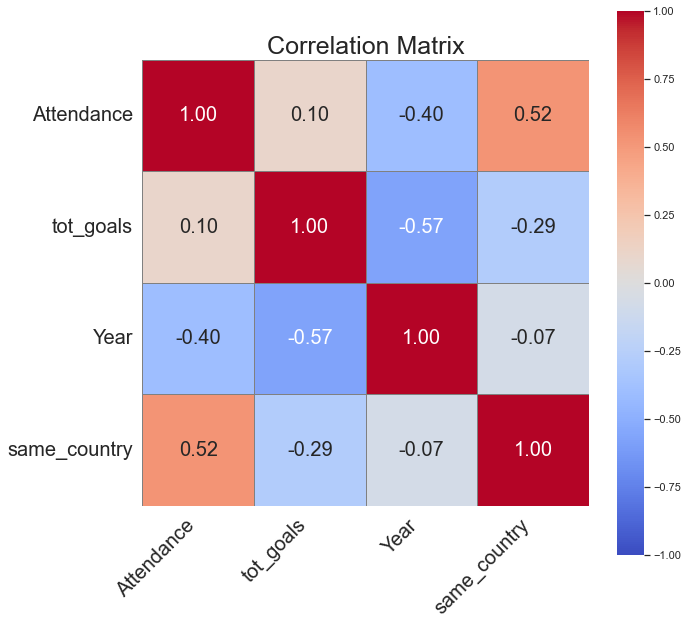

In [144]:
plt.figure(figsize=(10,10))

corr_finals=finals.select_dtypes(include=['number','bool']).corr().drop(
    columns=['win_score','run_score','same_country_win','same_country_loss']).corr(method='spearman')

sns.heatmap(corr_finals, 
            annot=True,           # Annotate the cells with the correlation values
            fmt='.2f',            # Format the annotation text (two decimal places)
            cmap='coolwarm',      # Choose a color map
            cbar=True,            # Show the color bar
            square=True,          # Make each cell square-shaped
            linewidths=.5,        # Add space between the cells
            linecolor='gray',     # Color of the lines between cells
            annot_kws={"size": 20},# Annotation font size
            vmin=-1, vmax=1)      # Set the min and max values for the color scale

# Set titles and labels for clarity
plt.title('Correlation Matrix', fontsize=25)
plt.xticks(rotation=45, ha='right', fontsize=20)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=20)               # Rotate y-axis labels

# Display the plot
plt.savefig(path+os.sep+'finals_corr.png',dpi=300,bbox_inches='tight')

In [145]:
#home_games contain all the goals scored by the home team in the final
home_games=pd.concat([finals[finals['same_country_win']]['win_score'], finals[finals['same_country_loss']]['run_score']], 
                     ignore_index=True)

#away_games contain all the goals scored by the visitor team in the final against a home team
away_games=pd.concat([finals[finals['same_country_win']]['run_score'], finals[finals['same_country_loss']]['win_score']], 
                     ignore_index=True)

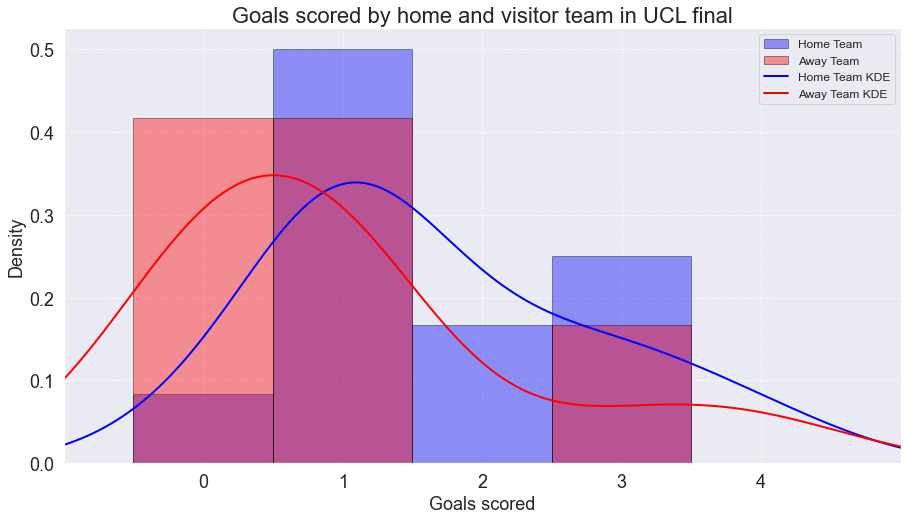

In [146]:
# Define bins and shift them slightly to the left
bins = [0, 1, 2, 3, 4]

# Create the plot
plt.figure(figsize=(15, 8))

# Plot the histograms centered on the left bin
plt.hist(home_games, bins=bins, alpha=0.4, color='blue', edgecolor='black', label='Home Team', density=True, align='left')
plt.hist(away_games, bins=bins, alpha=0.4, color='red', edgecolor='black', label='Away Team', density=True, align='left')

# Overplot KDE line distributions
sns.kdeplot(home_games, color='blue', lw=2, label='Home Team KDE')
sns.kdeplot(away_games, color='red', lw=2, label='Away Team KDE')

# Set x-ticks only for 0, 1, 2, 3, 4
plt.xticks([0, 1, 2, 3, 4])
plt.xlim(-1,5)

# Add titles and labels
plt.title('Goals scored by home and visitor team in UCL final', fontsize=22)
plt.xlabel('Goals scored', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both',labelsize=18)

# Add a legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.savefig(path+os.sep+'goals_home_visitor.png',dpi=300,bbox_inches='tight')

In [147]:
stats.shapiro(home_games),stats.shapiro(away_games)

(ShapiroResult(statistic=np.float64(0.8715269287262765), pvalue=np.float64(0.0683320330053219)),
 ShapiroResult(statistic=np.float64(0.7496111815027156), pvalue=np.float64(0.0026474909696389526)))

In [148]:
from scipy.stats import mannwhitneyu

mannwhitneyu(home_games, away_games,use_continuity=True, alternative='two-sided', method='auto')

MannwhitneyuResult(statistic=np.float64(100.0), pvalue=np.float64(0.09174361376369379))